### BPMN + Event Log → Enriched Log with Conformance Column


In [1]:
import pm4py
import os 
import pandas as pd



### BPMN to Petri Net Conversion


In [2]:
bpmn_file = os.path.join("conformance_checking_data","input", "road_fines_strict_v2.xml")

bpmn_model = pm4py.read_bpmn(bpmn_file)

net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_model)

net, initial_marking, final_marking

(places: [ ent_Activity_072ai1y, ent_Activity_0erkx34, ent_Activity_0k3s54a, ent_Gateway_01cry8c, ent_Gateway_0b9km4f, ent_Gateway_0bmvfo3, ent_Gateway_0zr5ng3, exi_Gateway_05elawd, exi_Gateway_0b9km4f, exi_Gateway_0bmvfo3, exi_Gateway_102n3fe, exi_Gateway_15eahro, exi_id6177f83c-1caf-4c90-944c-a7b5e6e057bb, exi_idb7adf069-fc63-43b5-b3e1-64b2ff2f592b, sink, source ]
 transitions: [ (Activity_072ai1y, 'Notify Result Appeal to Offender'), (Activity_0erkx34, 'Receive Result Appeal from Prefecture'), (Activity_0k3s54a, 'Send Appeal to Prefecture'), (Activity_0mteeno, 'Send for Credit Collection'), (Activity_1bq72bp, 'Insert Date Appeal to Prefecture'), (Activity_1touuxu, 'Appeal to Judge'), (Gateway_01cry8c, None), (Gateway_0b9km4f, None), (Gateway_0bmvfo3, None), (id11638e69-2f09-431c-baa3-c4040ab14cbf, 'Create Fine'), (id5f688aaf-fb9b-45fc-8eb8-e2a7174c4ce3, 'Add penalty'), (idb70c6d1a-b5f4-4e61-a22a-781cf12cedc0, 'Send Fine'), (idb7adf069-fc63-43b5-b3e1-64b2ff2f592b, 'Payment'), (iddfdd

### Visualization of the Petri Net


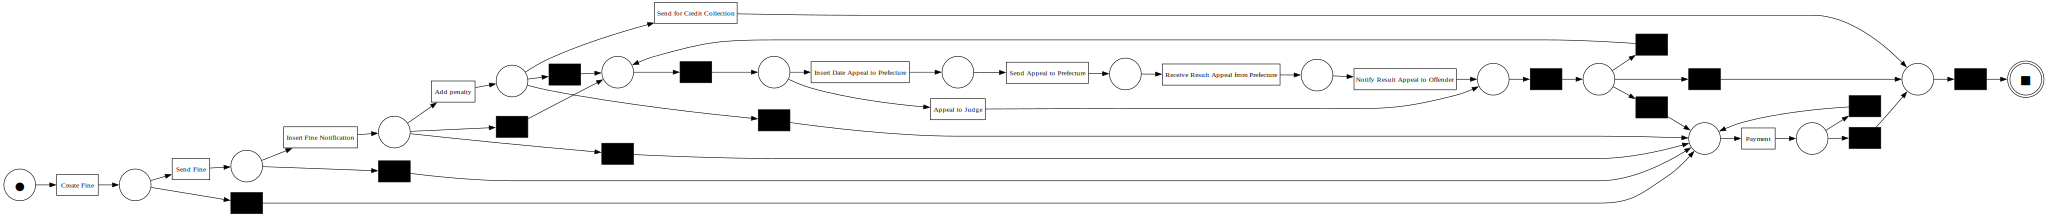

In [3]:
from IPython.display import SVG, display

from pm4py.visualization.petri_net import visualizer as pn_visualizer

parameters = {
    pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "svg", # svg for better quality inside notebook
    # pn_visualizer.Variants.WO_DECORATION.value.Parameters.RANKDIR: "TB",  # top to Bottom
}

# Generate the Petri net visualization
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
pn_visualizer.save(gviz, os.path.join("conformance_checking_data", "output","petri_net_visualization.svg"), parameters=parameters)

display(SVG(filename=os.path.join("conformance_checking_data", "output","petri_net_visualization.svg")))


### Import csv


In [4]:
csv_path = os.path.join("conformance_checking_data","input","road_traffic_fine.csv")
df = pd.read_csv(csv_path)


df.head(5)

,amount,org:resource,dismissal,Activity,vehicleClass,totalPaymentAmount,lifecycle:transition,Timestamp,article,points,CaseId,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


### Convert csv to an Event Log

In [5]:
log_df = pm4py.format_dataframe(df, 
                               case_id='CaseId', 
                               activity_key='Activity', 
                               timestamp_key='Timestamp')
event_log = pm4py.convert_to_event_log(log_df)

event_log[0]

{'attributes': {'concept:name': 'A1'}, 'events': [{'amount': 35.0, 'org:resource': 561.0, 'dismissal': 'NIL', 'Activity': 'Create Fine', 'vehicleClass': 'A', 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'Timestamp': Timestamp('2006-07-24 00:00:00+0000', tz='UTC'), 'article': 157.0, 'points': 0.0, 'CaseId': 'A1', 'expense': nan, 'notificationType': nan, 'lastSent': nan, 'paymentAmount': nan, 'matricola': nan, 'concept:name': 'Create Fine', 'time:timestamp': Timestamp('2006-07-24 00:00:00+0000', tz='UTC'), '@@index': 0, '@@case_index': 0}, '..', {'amount': nan, 'org:resource': nan, 'dismissal': nan, 'Activity': 'Send Fine', 'vehicleClass': nan, 'totalPaymentAmount': nan, 'lifecycle:transition': 'complete', 'Timestamp': Timestamp('2006-12-05 00:00:00+0000', tz='UTC'), 'article': nan, 'points': nan, 'CaseId': 'A1', 'expense': 11.0, 'notificationType': nan, 'lastSent': nan, 'paymentAmount': nan, 'matricola': nan, 'concept:name': 'Send Fine', 'time:timestamp': Timestamp('20

### Compute alignments

In [6]:
alignments = pm4py.conformance_diagnostics_alignments(event_log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

### Use alignments to map conformance/non-conformance for each trace

In [7]:

conformance_map = {}

for i in range(len(event_log)):
    case_id = event_log[i].attributes['concept:name']
    fitness = alignments[i]['fitness']
    conformance_map[case_id] = "conformant" if fitness == 1.0 else "non-conformant"

df['conformance_status'] = df['CaseId'].map(conformance_map)

print(df['conformance_status'].value_counts())

conformance_status
conformant        456725
non-conformant    104745
Name: count, dtype: int64


### Save the new event log


In [8]:
df.to_csv(os.path.join("conformance_checking_data","output", "enriched_road_fines_log.csv"), index=False)

enriched_df = df

enriched_df[['CaseId', 'Activity', 'conformance_status']].head(20)

,CaseId,Activity,conformance_status
0,A1,Create Fine,non-conformant
1,A1,Send Fine,non-conformant
2,A100,Create Fine,conformant
3,A100,Send Fine,conformant
4,A100,Insert Fine Notification,conformant
5,A100,Add penalty,conformant
6,A100,Send for Credit Collection,conformant
7,A10000,Create Fine,conformant
8,A10000,Send Fine,conformant
9,A10000,Insert Fine Notification,conformant
